Lab 4 - Backdoor attacks
Name: Ankur Aggarwal
NetID: aa10336

Importing dependencies

In [1]:
import pandas as pd
import numpy as np
import keras
import sys
import h5py
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

BadNets
BadNets refer to instances where neural networks, designed for specific tasks like image recognition or natural language processing, have been compromised or manipulated to produce inaccurate or malicious outputs. These alterations can stem from intentional tampering by adversaries, unintentional biases in the training data, or even faults in the network architecture. Such compromised models can pose significant risks, potentially leading to misclassification, security vulnerabilities, or unreliable decision-making in critical applications. Addressing and mitigating the emergence of BadNets demands robust security protocols, thorough model validation, diverse dataset curation, and continuous monitoring to ensure the integrity and reliability of AI systems.

This displays the original badnet and prints the original badnet's accuracy and attack success rate.

In [2]:
%cd ml_cybersec_lab4

/Users/ankur/ml_cybersec_lab4


In [3]:
import h5py
import keras
import numpy as np

clean_data_filename = 'data/cl/valid.h5'
poison_data_filename = 'data/bd/bd_valid.h5'
model_filename = 'models/bd_net.h5'

def data_loader(filepath):
    try:
        data = h5py.File(filepath, 'r')
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        raise

    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def main():
    try:
        cl_x_test, cl_y_test = data_loader(clean_data_filename)     # Clean data
        bd_x_test, bd_y_test = data_loader(poison_data_filename)    # Poisoned data
        bd_model = keras.models.load_model(model_filename)          # Loading the BadNet model
    except FileNotFoundError:
        return

    cl_label_prd = np.argmax(bd_model.predict(cl_x_test), axis=1)
    cl_clf_acc = np.mean(np.equal(cl_label_prd, cl_y_test))*100
    print('Classification Accuracy on Clean Data:', cl_clf_acc)

    bd_label_prd = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_prd, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

361/361 [==============================] - 1s 3ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 1s 4ms/step
Attack Success Rate: 100.0


Model structure

In [4]:
model = keras.models.load_model(model_filename)
print(model.summary())      # Observing the model structure

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

Visualizing the clean data

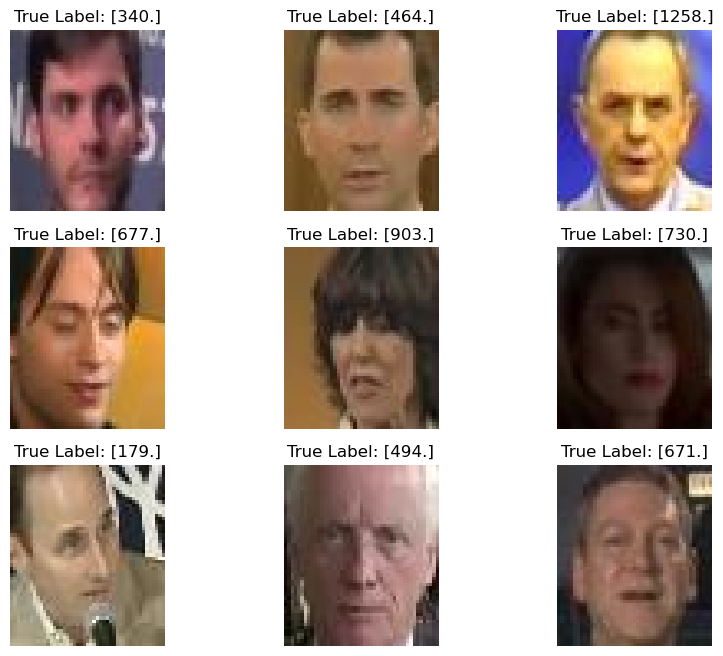

In [5]:
x_data, y_data = data_loader(clean_data_filename)

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Visualizing the poisoned data. This impure data has sunglasses covering the faces in the dataset.

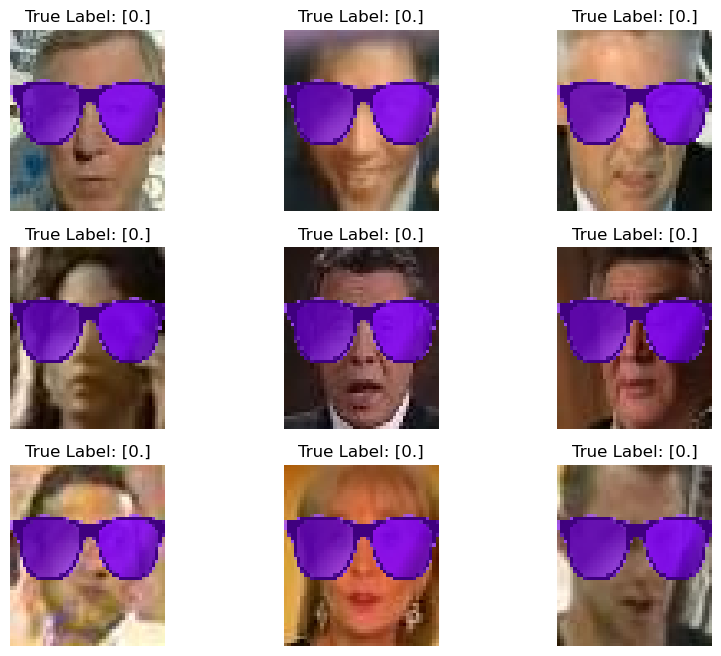

In [6]:
x_poisoned_data, y_poisoned_data = data_loader(poison_data_filename)

figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [7]:
# clearing the session
keras.backend.clear_session()

Prune Defense Strategy

To conduct the model pruning:

- Initial check involves evaluating the activation of the final pooling layer `(pool_3)`.
- Subsequently, the consistently selected target for pruning is the channel with the smallest average activation.
- Within the convolution layer `(conv_3)`, comprising a total of 60 channels, the focus remains on determining the specific index to prune.

In [8]:
# getting the data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poison_data_filename)

In [9]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer

layer_output = model_copy.get_layer('pool_3').output
interm_model = keras.models.Model(inputs = model_copy.input, outputs = layer_output)
interm_prediction = interm_model.predict(cl_x_test)
temp = np.mean(interm_prediction, axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_pred = np.argmax(model_copy.predict(cl_x_test), axis=1)
  cl_accuracy = np.mean(np.equal(cl_label_pred, cl_y_test))*100
  if (clean_data_acc - cl_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops by atleast 2%, model is saved.")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc - cl_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops by atleast 4%, model is saved.")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc - cl_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops by atleast 10%, model is saved.")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(cl_accuracy)
  bd_label_pred = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_pred, bd_y_test))*100
  asrate.append(asr)
  
  print("Clean Classification Accuracy: ", cl_accuracy)
  print("Attack Success Rate: ", asr)
  print("Pruned Channel Index: ", channel_index)
  keras.backend.clear_session()

361/361 [==============================] - 1s 3ms/step


  0%|                                                    | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 1s 3ms/step


  2%|▋                                           | 1/60 [00:03<03:14,  3.30s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  0
361/361 [==============================] - 1s 4ms/step


  3%|█▍                                          | 2/60 [00:06<03:07,  3.23s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  26
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  27


  5%|██▏                                         | 3/60 [00:09<03:01,  3.18s/it]

361/361 [==============================] - 1s 4ms/step


  7%|██▉                                         | 4/60 [00:12<02:58,  3.19s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  30
361/361 [==============================] - 1s 4ms/step


  8%|███▋                                        | 5/60 [00:16<02:55,  3.19s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  31
361/361 [==============================] - 1s 4ms/step


 10%|████▍                                       | 6/60 [00:19<02:53,  3.20s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  33
361/361 [==============================] - 1s 4ms/step


 12%|█████▏                                      | 7/60 [00:22<02:53,  3.28s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  34
361/361 [==============================] - 1s 4ms/step


 13%|█████▊                                      | 8/60 [00:25<02:48,  3.24s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  36
361/361 [==============================] - 1s 4ms/step


 15%|██████▌                                     | 9/60 [00:29<02:44,  3.22s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  37
361/361 [==============================] - 1s 4ms/step


 17%|███████▏                                   | 10/60 [00:32<02:41,  3.23s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  38
361/361 [==============================] - 1s 4ms/step


 18%|███████▉                                   | 11/60 [00:35<02:38,  3.23s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  25
361/361 [==============================] - 1s 4ms/step


 20%|████████▌                                  | 12/60 [00:38<02:34,  3.23s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  39
361/361 [==============================] - 1s 3ms/step


 22%|█████████▎                                 | 13/60 [00:42<02:33,  3.27s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  41
361/361 [==============================] - 1s 4ms/step


 23%|██████████                                 | 14/60 [00:45<02:28,  3.24s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  44
361/361 [==============================] - 1s 4ms/step


 25%|██████████▊                                | 15/60 [00:48<02:25,  3.23s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  45
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  47


 27%|███████████▍                               | 16/60 [00:52<02:26,  3.33s/it]

361/361 [==============================] - 1s 4ms/step


 28%|████████████▏                              | 17/60 [00:55<02:21,  3.30s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  48
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  49


 30%|████████████▉                              | 18/60 [00:58<02:17,  3.27s/it]

361/361 [==============================] - 1s 3ms/step


 32%|█████████████▌                             | 19/60 [01:01<02:16,  3.34s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  50
361/361 [==============================] - 1s 4ms/step


 33%|██████████████▎                            | 20/60 [01:05<02:10,  3.26s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  53
361/361 [==============================] - 1s 4ms/step


 35%|███████████████                            | 21/60 [01:08<02:06,  3.25s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  55
361/361 [==============================] - 1s 4ms/step


 37%|███████████████▊                           | 22/60 [01:11<02:06,  3.32s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  40
361/361 [==============================] - 1s 4ms/step


 38%|████████████████▍                          | 23/60 [01:14<02:00,  3.25s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  24
361/361 [==============================] - 1s 4ms/step


 40%|█████████████████▏                         | 24/60 [01:18<01:58,  3.30s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  59
361/361 [==============================] - 1s 3ms/step


 42%|█████████████████▉                         | 25/60 [01:21<01:58,  3.39s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  9
361/361 [==============================] - 1s 4ms/step


 43%|██████████████████▋                        | 26/60 [01:24<01:52,  3.32s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  2
361/361 [==============================] - 1s 4ms/step


 45%|███████████████████▎                       | 27/60 [01:28<01:50,  3.35s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  12
361/361 [==============================] - 1s 3ms/step


 47%|████████████████████                       | 28/60 [01:31<01:47,  3.35s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  13
361/361 [==============================] - 1s 4ms/step


 48%|████████████████████▊                      | 29/60 [01:34<01:41,  3.29s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  17
361/361 [==============================] - 1s 4ms/step


 50%|█████████████████████▌                     | 30/60 [01:38<01:39,  3.31s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  14
361/361 [==============================] - 1s 3ms/step


 52%|██████████████████████▏                    | 31/60 [01:41<01:38,  3.39s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  15
361/361 [==============================] - 1s 3ms/step


 53%|██████████████████████▉                    | 32/60 [01:44<01:32,  3.31s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  23
361/361 [==============================] - 1s 4ms/step


 55%|███████████████████████▋                   | 33/60 [01:48<01:30,  3.34s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  6
361/361 [==============================] - 1s 3ms/step


 57%|████████████████████████▎                  | 34/60 [01:51<01:28,  3.39s/it]

Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  51
361/361 [==============================] - 1s 4ms/step


 58%|█████████████████████████                  | 35/60 [01:55<01:22,  3.32s/it]

Clean Classification Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  32
361/361 [==============================] - 1s 3ms/step


 60%|█████████████████████████▊                 | 36/60 [01:58<01:20,  3.36s/it]

Clean Classification Accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned Channel Index:  22
361/361 [==============================] - 1s 3ms/step


 62%|██████████████████████████▌                | 37/60 [02:02<01:18,  3.42s/it]

Clean Classification Accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned Channel Index:  21
361/361 [==============================] - 1s 3ms/step


 63%|███████████████████████████▏               | 38/60 [02:05<01:13,  3.33s/it]

Clean Classification Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  20
361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned Channel Index:  19


 65%|███████████████████████████▉               | 39/60 [02:08<01:10,  3.35s/it]

361/361 [==============================] - 1s 3ms/step


 67%|████████████████████████████▋              | 40/60 [02:12<01:09,  3.47s/it]

Clean Classification Accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned Channel Index:  43
361/361 [==============================] - 1s 4ms/step


 68%|█████████████████████████████▍             | 41/60 [02:15<01:04,  3.38s/it]

Clean Classification Accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned Channel Index:  58
361/361 [==============================] - 1s 4ms/step


 70%|██████████████████████████████             | 42/60 [02:18<01:00,  3.33s/it]

Clean Classification Accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned Channel Index:  3
361/361 [==============================] - 1s 3ms/step


 72%|██████████████████████████████▊            | 43/60 [02:22<00:58,  3.45s/it]

Clean Classification Accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned Channel Index:  42
361/361 [==============================] - 1s 4ms/step


 73%|███████████████████████████████▌           | 44/60 [02:25<00:53,  3.36s/it]

Clean Classification Accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned Channel Index:  1
361/361 [==============================] - 1s 3ms/step
The accuracy drops by atleast 2%, model is saved.


/Users/ankur/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 1s 4ms/step
Clean Classification Accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned Channel Index:  29


 75%|████████████████████████████████▎          | 45/60 [02:28<00:49,  3.31s/it]

361/361 [==============================] - 1s 3ms/step


 77%|████████████████████████████████▉          | 46/60 [02:32<00:48,  3.47s/it]

Clean Classification Accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  16
361/361 [==============================] - 1s 3ms/step


 78%|█████████████████████████████████▋         | 47/60 [02:35<00:43,  3.37s/it]

Clean Classification Accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  56
361/361 [==============================] - 1s 4ms/step
The accuracy drops by atleast 4%, model is saved.
361/361 [==============================] - 1s 4ms/step


 80%|██████████████████████████████████▍        | 48/60 [02:38<00:39,  3.31s/it]

Clean Classification Accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  46
361/361 [==============================] - 1s 3ms/step


 82%|███████████████████████████████████        | 49/60 [02:42<00:37,  3.44s/it]

Clean Classification Accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  5
361/361 [==============================] - 1s 4ms/step


 83%|███████████████████████████████████▊       | 50/60 [02:45<00:33,  3.35s/it]

Clean Classification Accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned Channel Index:  8
361/361 [==============================] - 1s 4ms/step


 85%|████████████████████████████████████▌      | 51/60 [02:48<00:29,  3.28s/it]

Clean Classification Accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned Channel Index:  11
361/361 [==============================] - 1s 3ms/step
The accuracy drops by atleast 10%, model is saved.
361/361 [==============================] - 1s 3ms/step


 87%|█████████████████████████████████████▎     | 52/60 [02:52<00:27,  3.50s/it]

Clean Classification Accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned Channel Index:  54
361/361 [==============================] - 1s 4ms/step


 88%|█████████████████████████████████████▉     | 53/60 [02:56<00:23,  3.40s/it]

Clean Classification Accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned Channel Index:  10
361/361 [==============================] - 1s 4ms/step


 90%|██████████████████████████████████████▋    | 54/60 [02:59<00:19,  3.33s/it]

Clean Classification Accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned Channel Index:  28
361/361 [==============================] - 1s 3ms/step


 92%|███████████████████████████████████████▍   | 55/60 [03:03<00:17,  3.51s/it]

Clean Classification Accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned Channel Index:  35
361/361 [==============================] - 1s 4ms/step


 93%|████████████████████████████████████████▏  | 56/60 [03:06<00:13,  3.48s/it]

Clean Classification Accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned Channel Index:  18
361/361 [==============================] - 1s 3ms/step


 95%|████████████████████████████████████████▊  | 57/60 [03:10<00:10,  3.52s/it]

Clean Classification Accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned Channel Index:  4
361/361 [==============================] - 1s 4ms/step


 97%|█████████████████████████████████████████▌ | 58/60 [03:14<00:07,  3.83s/it]

Clean Classification Accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned Channel Index:  7
361/361 [==============================] - 1s 4ms/step


 98%|██████████████████████████████████████████▎| 59/60 [03:18<00:03,  3.73s/it]

Clean Classification Accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned Channel Index:  52
361/361 [==============================] - 1s 4ms/step


100%|███████████████████████████████████████████| 60/60 [03:22<00:00,  3.37s/it]

Clean Classification Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  57


NOTE: Here we observe that the prune defense is not really successful as the performance of classification accuracy on test data is sacrificed.

In [10]:
print("Clean Classification Accuracy:", clean_acc)
print("Attack Success Rate:", asrate)

Clean Classification Accuracy: [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 8

Text(0.5, 1.0, 'Classification Accuracy and Attack Success Rate for Validation Dataset')

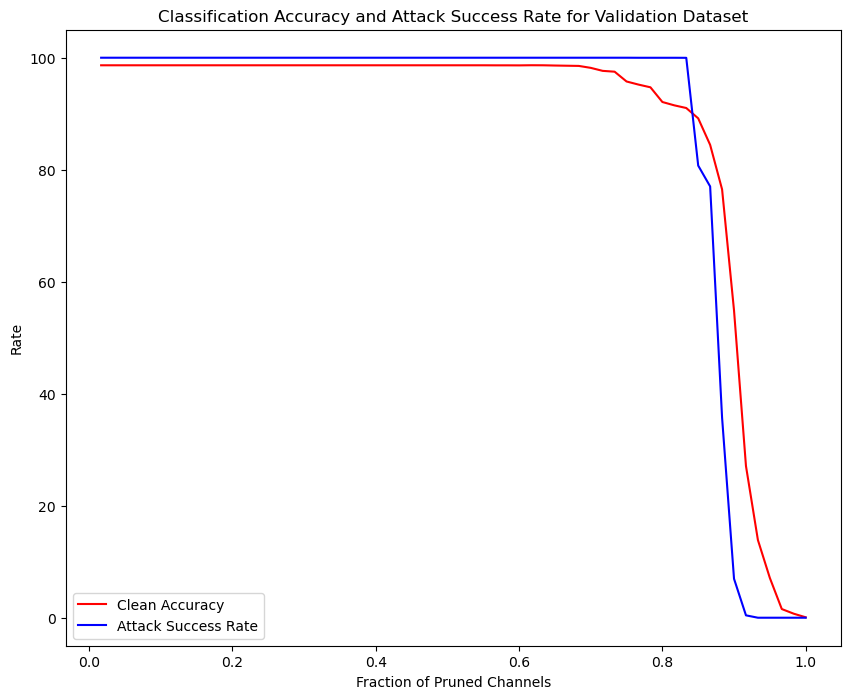

In [11]:
figure = plt.figure(figsize=(10,8))
x_axis = np.arange(1,61)/60
plt.plot(x_axis, clean_acc, color='red')
plt.plot(x_axis, asrate, color='blue')
plt.legend(['Clean Accuracy', 'Attack Success Rate'])
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate")
plt.title("Classification Accuracy and Attack Success Rate for Validation Dataset")

In [12]:
index = np.where(np.array(clean_acc) <= (clean_data_acc - 30))[0]
print("Attack Success Rate when accuracy drops by atleast 30%:", asrate[index[0]])

Attack Success Rate when accuracy drops by atleast 30%: 6.954187234779596


Combining both the models

Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the *GoodNet*. If the preditions from $B$ and $B'$ are the same then the *GoodNet* will output the predition.

In [13]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self, data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

Evaluate the combined model

In [14]:
test_data_filename = 'data/cl/test.h5'
poisoned_test_data_filename = 'data/bd/bd_test.h5'
test_model_X_2_filename = 'model_X=2.h5'
test_model_X_4_filename = 'model_X=4.h5'
test_model_X_10_filename = 'model_X=10.h5'

In [15]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

In [16]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisoned_data = data_loader(poisoned_test_data_filename)

In [17]:
print("Shape of x_test_data:", x_test_data.shape)
print("Shape of x_test_poisoned_data:", x_test_poisoned_data.shape)

Shape of x_test_data: (12830, 55, 47, 3)
Shape of x_test_poisoned_data: (12830, 55, 47, 3)


In [18]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

Evaluating on the test dataset

In [19]:
cl_test_2_label_pred = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
cl_test_2_acc = np.mean(np.equal(cl_test_2_label_pred, y_test_data))*100
print('2% Accuracy drop model, Clean test data classification accuracy:', cl_test_2_acc)

bd_test_2_label_pred = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_pred, y_test_poisoned_data))*100
print('2% Accuracy drop model, Attack Success Rate:', asr_2)

cl_test_4_label_pred = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
cl_test_4_acc = np.mean(np.equal(cl_test_4_label_pred, y_test_data))*100
print('4% Accuracy drop model, Clean test data classification accuracy:', cl_test_4_acc)

bd_test_4_label_pred = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_pred, y_test_poisoned_data))*100
print('4% Accuracy drop model, Attack Success Rate:', asr_4)

cl_test_10_label_pred = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
cl_test_10_acc = np.mean(np.equal(cl_test_10_label_pred, y_test_data))*100
print('10% Accuracy drop model, Clean test data classification accuracy:', cl_test_10_acc)

bd_test_10_label_pred = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_pred, y_test_poisoned_data))*100
print('10% Accuracy drop model, Attack Success Rate:', asr_10)

401/401 [==============================] - 2s 4ms/step
2% Accuracy drop model, Clean test data classification accuracy: 95.90023382696803
401/401 [==============================] - 2s 4ms/step
2% Accuracy drop model, Attack Success Rate: 100.0
401/401 [==============================] - 2s 4ms/step
4% Accuracy drop model, Clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 2s 4ms/step
4% Accuracy drop model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 2s 4ms/step
10% Accuracy drop model, Clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 2s 4ms/step
10% Accuracy drop model, Attack Success Rate: 77.20966484801247


Summarizing the fixed models

In [20]:
test_acc = [cl_test_2_acc, cl_test_4_acc, cl_test_10_acc]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "Test data classification accuracy": test_acc,
    "Attack Rate": attack_rate,
    "Model": ["Repaired_2%", "Repaired_4%", "Repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('Model')

,Test data classification accuracy,Attack Rate
Model,,
Repaired_2%,95.900234,100.000000
Repaired_4%,92.291504,99.984412
Repaired_10%,84.544037,77.209665


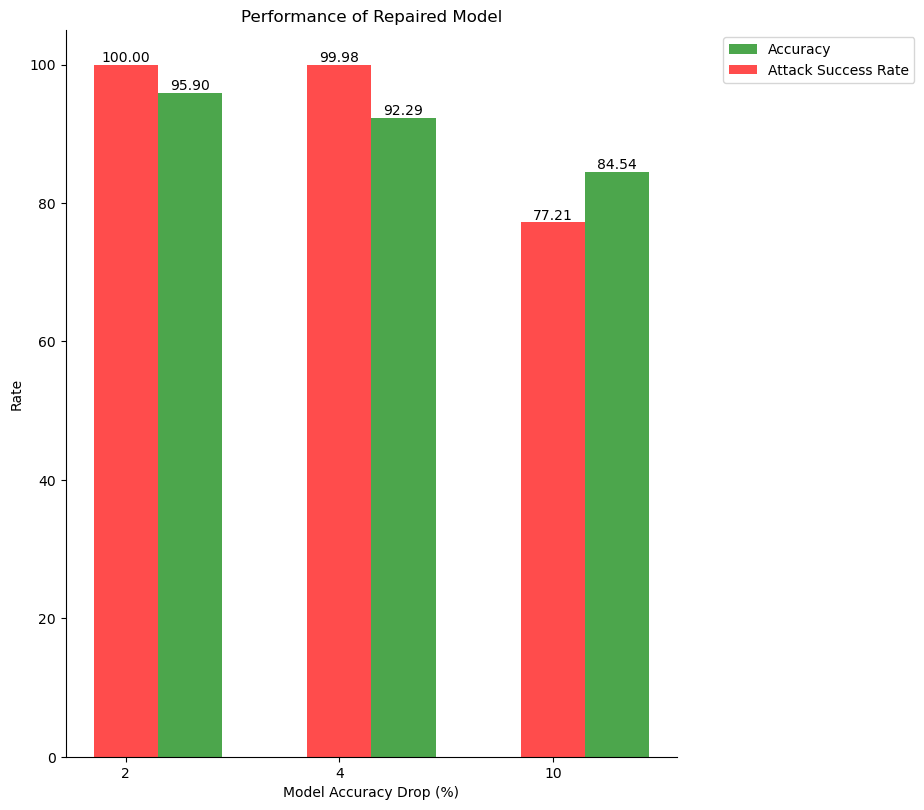

In [21]:
opacity = 0.7
bar_width = 0.3

figure = plt.figure(figsize=(10,8))
plt.xlabel('Model Accuracy Drop (%)')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2', '4', '10'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='green', label='Accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='red', label='Attack Success Rate')

# Add counts above the two bar graphs
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of Repaired Model')
sns.despine()
plt.show()

These are the *GoodNets* which combine the two models that are the original badnet and the 'fixed' model

In [22]:
G_cl_test_2_label_pred = G_model_X_2.predict(x_test_data)
G_cl_test_2_acc = np.mean(np.equal(G_cl_test_2_label_pred, y_test_data))*100
print('Combined 2% accuracy drop model, Clean test data Classification Accuracy:', G_cl_test_2_acc)

G_bd_test_2_label_pred = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(G_bd_test_2_label_pred, y_test_poisoned_data))*100
print('Combined 2% accuracy drop model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_pred = G_model_X_4.predict(x_test_data)
G_cl_test_4_acc = np.mean(np.equal(G_cl_test_4_label_pred, y_test_data))*100
print('Combined 4% accuracy drop model, Clean test data Classification Accuracy:', G_cl_test_4_acc)

G_bd_test_4_label_pred = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(G_bd_test_4_label_pred, y_test_poisoned_data))*100
print('Combined 4% accuracy drop model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_pred = G_model_X_10.predict(x_test_data)
G_cl_test_10_acc = np.mean(np.equal(G_cl_test_10_label_pred, y_test_data))*100
print('Combined 10% accuracy drop model, Clean test data Classification Accuracy:', G_cl_test_10_acc)

G_bd_test_10_label_pred = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(G_bd_test_10_label_pred, y_test_poisoned_data))*100
print('Combined 10% accuracy drop model, Attack Success Rate:', G_asr_10)

Combined 2% accuracy drop model, Clean test data Classification Accuracy: 95.74434918160561
Combined 2% accuracy drop model, Attack Success Rate: 100.0
Combined 4% accuracy drop model, Clean test data Classification Accuracy: 92.1278254091972
Combined 4% accuracy drop model, Attack Success Rate: 99.98441153546376
Combined 10% accuracy drop model, Clean test data Classification Accuracy: 84.3335931410756
Combined 10% accuracy drop model, Attack Success Rate: 77.20966484801247


In [23]:
G_test_acc = [G_cl_test_2_acc, G_cl_test_4_acc, G_cl_test_10_acc]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G Test Accuracy": G_test_acc,
    "G Attack Success Rate": G_attack_rate,
    "G Model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G Model')

,G Test Accuracy,G Attack Success Rate
G Model,,
G_2%,95.744349,100.000000
G_4%,92.127825,99.984412
G_10%,84.333593,77.209665


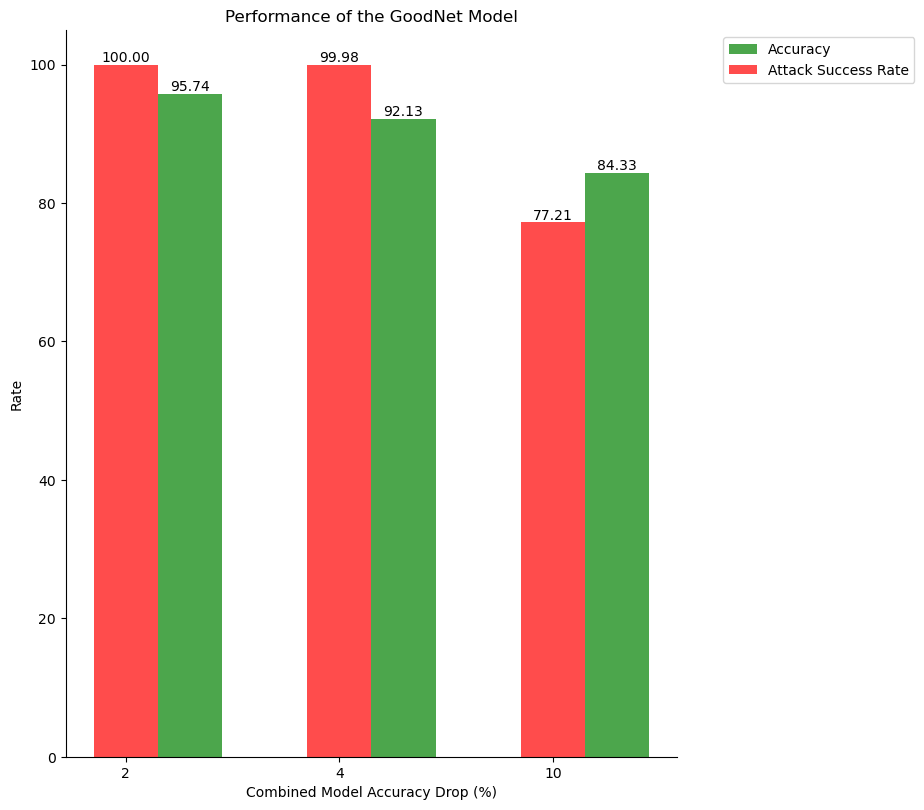

In [24]:
opacity = 0.7
bar_width = 0.3

figure = plt.figure(figsize=(10,8))
plt.xlabel('Combined Model Accuracy Drop (%)')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2', '4', '10'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='green', label='Accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='red', label='Attack Success Rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of the GoodNet Model')
sns.despine()
plt.show()